In [ ]:
# IN GOOGLE COLAB:
####################################################################################################################################################
## STEP 1: Make the ZIP file public on Google Drive and copy the id from the link:
# Example: https://drive.google.com/file/d/1LPTpBnfkl7tWDifJD5CLQUnNO8nvsDZX/view?usp=sharing
# ID: 1LPTpBnfkl7tWDifJD5CLQUnNO8nvsDZX
####################################################################################################################################################
## STEP 2: Download the ZIP file from Google Drive using the id:
#!gdown --id 1LPTpBnfkl7tWDifJD5CLQUnNO8nvsDZX
####################################################################################################################################################
## STEP 3: Unzip the file:
#!unzip /content/EMNIST_Version.zip
####################################################################################################################################################
## STEP 4 (not necessary): Change the working directory
#%cd EMNIST_Version
#!pwd #Check that you are in the desired directory
#!ls #See what files are inside
####################################################################################################################################################

In [1]:
####################################################################################################################################################
# LIBRARIES:
import os
import tensorflow as tf
from tensorflow import keras
####################################################################################################################################################
## FUNCTIONS:
def model_assembler():

    # Load the input layer and data augmentation layers [1/8 -> pi/4] (slightly less rotation):
    input_ly = keras.Input(shape=[28, 28, 1], dtype=tf.float32)
    aug_ly = keras.layers.RandomRotation(factor=(-1/20, 1/20), fill_mode="nearest", interpolation="nearest", seed=177)(input_ly)
    aug_ly = keras.layers.RandomZoom(height_factor=(0, 0.05), width_factor=None, fill_mode="nearest", interpolation="nearest", seed=177)(aug_ly)
    aug_ly = keras.layers.RandomTranslation(height_factor=(0, 0.05), width_factor=(0, 0.05), fill_mode="nearest", interpolation="nearest", seed=177)(aug_ly)
    
    # Add the first convolutional layer:
    conv1_ly = keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu")(aug_ly)
    conv1_ly = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1_ly)

    # Add the second convolutional layer:
    conv2_ly = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu")(conv1_ly)
    conv2_ly = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2_ly)

    # Regularize from convolutional to dense and apply dropout:
    dropout_ly = keras.layers.Dropout(rate=0.5, seed=117)(conv2_ly)
    dense_ly = keras.layers.Flatten()(dropout_ly)

    # Add dense layers and the output layer of 62 classes:
    dense1_ly = keras.layers.Dense(units=100, activation="relu")(dense_ly)
    output_ly = keras.layers.Dense(units=47, activation="softmax")(dense1_ly)
    
    # Create the model and return:
    model = keras.Model(inputs=input_ly, outputs=[output_ly], name="TFM_EMNIST")
    return model
####################################################################################################################################################
## MAIN: Create the model and visualize its structure

# Get the working directory:
work_path = os.getcwd()

# Create the model and visualize:
Chars74k_model = model_assembler()
Chars74k_model.summary()
keras.utils.plot_model(Chars74k_model, to_file=os.path.join(work_path, "TFM_EMNIST_diagram.pdf"), show_shapes=True, show_layer_names=True,
                       expand_nested=True, dpi=100, show_layer_activations=True)

Model: "TFM_EMNIST"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 random_rotation (RandomRota  (None, 28, 28, 1)        0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 28, 28, 1)         0         
                                                                 
 random_translation (RandomT  (None, 28, 28, 1)        0         
 ranslation)                                                     
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0

In [ ]:
# LIBRARIES:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
####################################################################################################################################################
## FUNCTIONS:

# Function 1: Load data from the "file" and convert it to the required format
def preporcess_data(file_csv):
    
    # NOTE: The input file "file" is a CSV file with thousands of rows and (1 + 28x28) columns.
    # Each column is separated by commas and has no header. Each row is a 28x28 pixel image with values
    # between [0-255] plus a "label" value (the first column). Associated with the CSV file is a TXT file that
    # transforms the "label" into the characters of the Dataset. This text file consists of two columns ("label"
    # [0-46] and ASCII code) separated by space. First, the TXT must be extracted, as its size allows for "one-hot encoding"
    # of the "labels".

    # Generate the name of the text file based on the "file":
    file_txt = file_csv.split("-")  # Keywords are separated by the "-" character
    file_txt = file_txt[0] + "-" + file_txt[1] + "-mapping.txt"  # Compose the TXT file name

    # Obtain the mapping between "labels" and characters, as per specifications:
    raw_map = pd.read_csv(file_txt, sep=" ", header=None)

    # NOTE: When using "read_csv" with "header=None," a generic header is generated that associates numbers from 0 to
    # the total number of columns with each column. This header will be numbers, not "Strings." Also, be careful
    # when deleting a column because the header is not updated, for example: If I delete column 0, the first column
    # will be 1, not 0.

    # Generate the dictionary that relates "label" to characters:
    label_map = raw_map.drop(0, axis="columns")  # Remove the first column that matches the index
    label_map[1] = label_map[1].apply(chr)  # Convert from ASCII code to character
    label_map = dict(enumerate(label_map[1].tolist()))  # Convert to a dictionary with the index (rows) as a guide

    # Read the data from the CSV, specifying the separator and that it has no header:
    raw_data = pd.read_csv(file_csv, sep=",", header=None)

    # Create the input set "x" (images):
    x = raw_data.drop(0, axis="columns")  # Remove the first "label" column
    x = x.astype("float32")  # Specify the data type
    x = x / 255  # Normalize pixel values between [0-1]
    x = x.values.reshape(-1, 28, 28, 1)  # Convert to a vector of 28x28x1 images
    x = np.transpose(x, [0, 2, 1, 3])  # Transpose height and width of the images 28x28

    # Create the output set "y" ("label") in "one-hot encoding" mode:
    y = keras.utils.to_categorical(raw_data[0], len(label_map))

    # Inform the user about the treated Dataset:
    print("\t- The extracted data has the shape: " + str(x.shape))
    print("\t- The data labels have the shape (\"one-hot encoding\" format): " + str(y.shape))
    print("\t- There are a total of " + str(len(label_map)) + " different labels. They are as follows: " + str(
        list(label_map.values())) + "\n")

    # Return the created sets:
    return x, y, label_map

# Function 2: Divide the incoming "dataset" into training and validation:
def dataset_splitter(train_data, split_factor, seed):

    # Extract the training "dataset" and its raw "labels":
    raw_train_x = train_data[0]
    raw_train_y = train_data[1]

    # Calculate how many components there are in total and how many are destined for "val":
    N_total = raw_train_x.shape[0]
    N_val = int(split_factor * N_total)

    # Configure the random number generator and select the components of each "dataset":
    rand_gen = np.random.default_rng(seed=seed)
    idx_val = rand_gen.choice(N_total, size=N_val, replace=False)
    idx_train = np.delete(np.arange(N_total), np.where(np.isin(np.arange(N_total), idx_val)))

    # Return each of the "datasets":
    return raw_train_x[idx_train], raw_train_y[idx_train], raw_train_x[idx_val], raw_train_y[idx_val]

# Function 3: Create the neural network model:
def model_assembler():

    # Load the input layer and data augmentation layers [1/8 -> pi/4] (slightly less rotation):
    input_ly = keras.Input(shape=[28, 28, 1], dtype=tf.float32)
    aug_ly = keras.layers.RandomRotation(factor=(-1/20, 1/20), fill_mode="nearest", interpolation="nearest", seed=177)(input_ly)
    aug_ly = keras.layers.RandomZoom(height_factor=(0, 0.05), width_factor=None, fill_mode="nearest", interpolation="nearest", seed=177)(aug_ly)
    aug_ly = keras.layers.RandomTranslation(height_factor=(0, 0.05), width_factor=(0, 0.05), fill_mode="nearest", interpolation="nearest", seed=177)(aug_ly)
    
    # Add the first convolutional layer:
    conv1_ly = keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu")(aug_ly)
    conv1_ly = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1_ly)

    # Add the second convolutional layer:
    conv2_ly = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu")(conv1_ly)
    conv2_ly = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2_ly)

    # Regularize from convolutional to dense and apply dropout:
    dropout_ly = keras.layers.Dropout(rate=0.5, seed=117)(conv2_ly)
    dense_ly = keras.layers.Flatten()(dropout_ly)

    # Add dense layers and the output layer of 62 classes:
    dense1_ly = keras.layers.Dense(units=100, activation="relu")(dense_ly)
    output_ly = keras.layers.Dense(units=47, activation="softmax")(dense1_ly)
    
    # Create the model and return:
    model = keras.Model(inputs=input_ly, outputs=[output_ly], name="TFM_EMNIST")
    return model
####################################################################################################################################################
## MAIN: Model Training from Scratch or Continuation

# Get the working directory, dataset directory, and checkpoints directory:
work_path = os.getcwd()
dataset_path = os.path.join(work_path, "EMNIST_Dataset")
ckp_path = os.path.join(work_path, "EMNIST_Model_Ckeckpoints")

# Set the name of the model from which training continues and the number of training epochs:
model_name = "TFM_EMNIST_model_ep100.keras"
num_epoch = 100

# Check if the model is found to continue training or if starting from scratch:
print("Looking for the model \"{}\" to be trained for {} epochs".format(model_name, num_epoch))
if not os.path.exists(os.path.join(ckp_path, model_name)):

    # Create the model and add the compiler:
    print("\t- The model \"{}\" was not found, so a new model is generated from scratch.\n".format(model_name))
    model_name = "TFM_EMNIST_model_ep0.keras"  # New model from scratch
    EMNIST_model = model_assembler()
    EMNIST_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
else:
    
    # The model is found, so its last state is loaded, and the custom optimizer is added:
    print("\t- The model \"{}\" is loaded, and training continues from where it left off.\n".format(model_name))
    custom_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    EMNIST_model = keras.models.load_model(os.path.join(ckp_path, model_name), custom_objects={"Custom>Adam": custom_opt})

# Check if a GPU is available for training (if not, do nothing):
print("Proceeding to train the model, but first, it must be determined if the GPU is operational:")
if tf.test.gpu_device_name() == "/device:GPU:0":
    
    # With an active GPU, load the datasets and train the model:
    print("\t- GPU is available for training the model \"{}\".".format(model_name))
    with tf.device("/device:GPU:0"):
        
        # Load the training dataset and split it to obtain the validation set:
        print("\t- Load the training dataset and generate the validation set:")
        x_train, y_train, _ = preporcess_data(os.path.join(dataset_path, "emnist-balanced-train.csv"))
        x_train, y_train, x_val, y_val = dataset_splitter((x_train, y_train), 0.2, 117)
        
        # Create the callbacks used by the model (save the complete model):
        print("\n\t- With the data loaded, training callbacks are set up.")
        checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckp_path, "CkeckPoints_epoch{epoch:03d}.keras"),
                                                              save_weights_only=False, monitor="val_accuracy", mode="max", save_best_only=True)
        earlystopp_callback = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10)
        
        # Train the model and generate the training history DataFrame:
        print("\t- Training the model \"{}\":".format(model_name))
        training_hist = EMNIST_model.fit(x_train, y_train, batch_size=128, epochs=num_epoch, validation_data=(x_val, y_val),
                                         callbacks=[checkpoint_callback, earlystopp_callback])
        hist_df = pd.DataFrame.from_dict(training_hist.history, orient="index").T
        
        # With training completed, determine up to which epoch it was trained, and save the weights/model:
        print("\t- Training completed, saving the model and data.")
        final_model = "TFM_EMNIST_model_ep" + str(int((model_name.split("ep")[1]).split(".")[0]) + len(hist_df)) + ".keras"
        EMNIST_model.save(os.path.join(ckp_path, final_model), overwrite=True)
        EMNIST_model.save_weights(os.path.join(ckp_path, final_model.replace("model", "weights").replace("keras", "h5")), overwrite=True)
        
        # Save the training data to a CSV file:
        hist_df.to_csv(os.path.join(ckp_path, "Performance_Data.csv"), sep=chr(9), index=False,
                       header=not os.path.exists(os.path.join(ckp_path, "Performance_Data.csv")))
                                                      
        # Load the test data and perform an evaluation of the model:
        print("\t- Load the test dataset and perform the evaluation:")
        x_test, y_test, _ = preporcess_data(os.path.join(dataset_path, "emnist-balanced-test.csv"))
        test_result = EMNIST_model.evaluate(x_test, y_test, batch_size=128)
        print("\t--> Evaluation result: \"Accuracy\" == {}% and \"Loss\" == {}".format(test_result[1] * 100, test_result[0]))
        print("\nProcess completed.")              

Characteristic training data:
	- Training: Maximum "Accuracy" value of 87.51440644264221% detected at epoch 67.
	- Training: Minimum "Loss" value of 0.3354093432426452 detected at epoch 66.
	- Validation: Maximum "Accuracy" value of 89.21985626220703% detected at epoch 57.
	- Validation: Minimum "Loss" value of 0.2994062304496765 detected at epoch 62.


Proceeding to visualize training data:



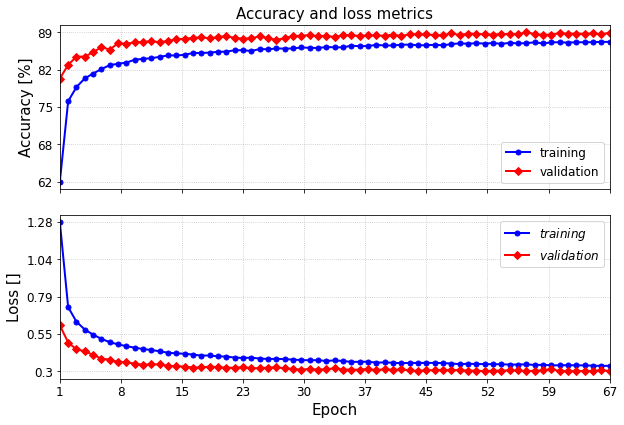

In [1]:
####################################################################################################################################################
## LIBRARIES:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
####################################################################################################################################################
## VISUALIZATION FUNCTIONS:

# Visualization Function 1: Represents training metrics
def model_performance_explorer(csv_file, save_flag):
    
    # Load data from CSV:
    hist_data = pd.read_csv(csv_file, sep=chr(9))

    # Extract training history data and mark characteristic points:
    epochs = np.arange(1, hist_data.shape[0] + 1)
    train_loss = np.array(hist_data["loss"])
    val_loss = np.array(hist_data["val_loss"])
    train_acc = np.array(hist_data["accuracy"]) * 100
    val_acc = np.array(hist_data["val_accuracy"]) * 100
    print("Characteristic training data:")
    print("\t- Training: Maximum \"Accuracy\" value of {}% detected at epoch {}.".format(np.amax(train_acc), np.argmax(train_acc) + 1))
    print("\t- Training: Minimum \"Loss\" value of {} detected at epoch {}.".format(np.amin(train_loss), np.argmin(train_loss) + 1))
    print("\t- Validation: Maximum \"Accuracy\" value of {}% detected at epoch {}.".format(np.amax(val_acc), np.argmax(val_acc) + 1))
    print("\t- Validation: Minimum \"Loss\" value of {} detected at epoch {}.\n".format(np.amin(val_loss), np.argmin(val_loss) + 1))
    
    # Create the figure and subplots for visualizing training data:
    print("\nProceeding to visualize training data:\n")
    fig, axs = plt.subplots(1, 2, figsize=(8.3, 11.7 / 2))
    # NOTE: A4 size is [210mm X 297mm] or [8.3in X 11.7in] (Width X Height). Generating an image for half of a letter-size page.

    # Plot the data for each subplot ("accuracy" & "loss"):
    axs[0].plot(epochs, train_acc, 'bo-', linewidth=2, markersize=5, label="training")
    axs[0].plot(epochs, val_acc, 'rD-', linewidth=2, markersize=5, label="validation")
    axs[0].grid(True, which="both", linestyle=":", alpha=0.8)
    axs[0].set_xlim(1, np.amax(epochs))
    axs[1].plot(epochs, train_loss, 'bo-', linewidth=2, markersize=5, label="$training$")
    axs[1].plot(epochs, val_loss, 'rD-', linewidth=2, markersize=5, label="$validation$")
    axs[1].grid(True, which="both", linestyle=":", alpha=0.8)
    axs[1].set_xlim(1, np.amax(epochs))

    # Identify maximum/minimum altered data for "xticks"/"yticks" of the "subplots":
    ep_max = np.max(epochs)
    ep_min = np.min(epochs)
    acc_max = np.max(np.maximum(train_acc, val_acc))
    acc_min = np.min(np.minimum(train_acc, val_acc))
    loss_max = np.max(np.maximum(train_loss, val_loss))
    loss_min = np.min(np.minimum(train_loss, val_loss))

    # Adjust the representation values of the X-Y axes for each subplot:
    axs[0].set_xticks(np.linspace(ep_min, ep_max, num=10))
    axs[0].set_xticklabels([], fontsize=12)
    axs[0].set_yticks(np.linspace(acc_min, acc_max, num=5))
    axs[0].set_yticklabels(axs[0].get_yticks().astype(np.int64), fontsize=12)
    axs[1].set_xticks(np.linspace(ep_min, ep_max, num=10))
    axs[1].set_xticklabels(axs[1].get_xticks().astype(np.int64), fontsize=12)
    axs[1].set_yticks(np.linspace(loss_min, loss_max, num=5))
    axs[1].set_yticklabels(np.round(axs[1].get_yticks(), decimals=2), fontsize=12)

    # Configure the axes of the "subplots":
    axs[0].set_position([0.06, 0.55, 0.92, 0.39])
    axs[1].set_position([0.06, 0.1, 0.92, 0.39])
    for ax in axs:
        for lb in ["top", "right", "bottom", "left"]:
            ax.spines[lb].set_visible(True)
    axs[0].set_title("Accuracy and loss metrics", fontsize=15)
    axs[0].set_ylabel("Accuracy [%]", fontsize=15)
    axs[0].legend(loc="lower right", fontsize=12)
    axs[1].set_ylabel("Loss []", fontsize=15)
    axs[1].set_xlabel("Epoch", fontsize=15)
    axs[1].legend(loc="upper right", fontsize=12)

    # Save the image, if authorized, and return the plot:
    if save_flag:
        plt.savefig(os.path.join(os.path.dirname(csv_file), "EMNIST_Training_Data.pdf"), format="pdf", bbox_inches="tight")
    return plt.gcf()
####################################################################################################################################################
## MAIN: Visualization of Training Metrics

# Get the working directory and the training data directory:
work_path = os.getcwd()
ckp_path = os.path.join(work_path, "EMNIST_Model_Ckeckpoints")

# Visualize the training data:
perf_fig = model_performance_explorer(os.path.join(ckp_path, "Performance_Data.csv"), True)
plt.show()